### 課題　Kick Starter Projectの成功の可否を判別する
* 尚、成功と失敗のみを考え、その他の状態(キャンセル等)考えないものとする。

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
import seaborn as sns
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix,precision_score,recall_score,f1_score,precision_recall_fscore_support
from datetime import datetime as dt
from datetime import timedelta
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from IPython.display import display
from IPython.display import Image
import os, sys, re, datetime, gc
from pathlib import Path
from itertools import product
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.compat.v1.keras import Sequential
from tensorflow.compat.v1.keras.layers import Dense, Dropout, Activation
from tensorflow.compat.v1.keras.optimizers import SGD,RMSprop, Adagrad, Adadelta, Adam
from tensorflow.keras.utils import to_categorical
from sklearn.svm import SVC # 分類
from common_func import plot_decision_regions # 決定領域表示関数

In [2]:
df_crowd = pd.read_csv('./ks-projects-201801.csv')
display(df_crowd.head())
display(df_crowd.describe())
display(df_crowd.info())
print(df_crowd.isnull().sum())
# goal=資金調達の目標、launched=発売日、pledged=出資金、backers=既に出資を決めた人数、usd~=米ドル換算、goal=目標金額、state=状態

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


None

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64


In [3]:
# 不必要と思われるデータを除外
df = df_crowd[['name','main_category','currency','deadline','goal','launched','state','backers','usd pledged','usd_pledged_real','usd_goal_real']]
print(df.isnull().sum())
print(df['state'].value_counts()) # underfined:未定義 suspended:一時停止

name                   4
main_category          0
currency               0
deadline               0
goal                   0
launched               0
state                  0
backers                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64
failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64


In [4]:
# 今回は成功か失敗かを知りたい⇒failedとsuccessfulのみ
df_f = df[df['state'] == 'failed']
df_s = df[df['state'] == 'successful']
df_fs =  df[(df['state'] == 'successful') | (df['state'] =='failed')]
# state=failed,successfulのみ表示
print(df_fs['state'].value_counts()) #除外出来ているか確認のため表示

failed        197719
successful    133956
Name: state, dtype: int64


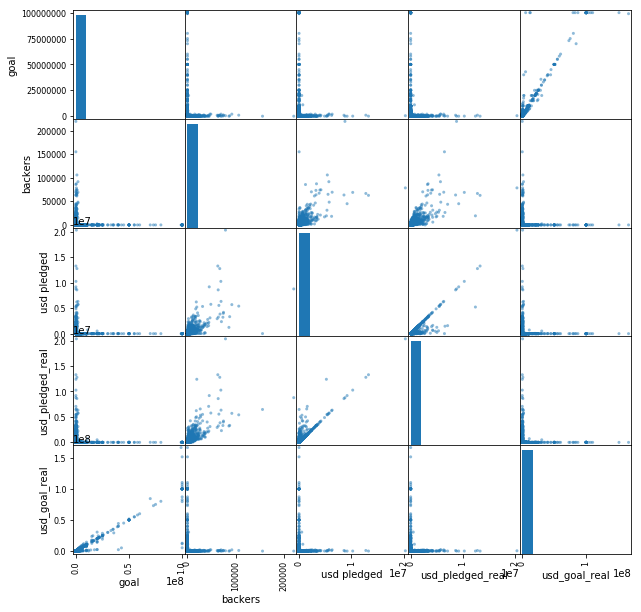

In [5]:
pd.plotting.scatter_matrix(df_fs,figsize=(10,10)) # 関係性の確認
plt.show()

In [5]:
display(df_fs.corr()) # 相関係数の確認

,goal,backers,usd pledged,usd_pledged_real,usd_goal_real
goal,1.000000,0.004794,0.006416,0.005955,0.952614
backers,0.004794,1.000000,0.697493,0.752291,0.005208
usd pledged,0.006416,0.697493,1.000000,0.907713,0.006965
usd_pledged_real,0.005955,0.752291,0.907713,1.000000,0.006354
usd_goal_real,0.952614,0.005208,0.006965,0.006354,1.000000


In [5]:
# 相関係数0.9以上で強い正の相関である
# goalとusd_goal、usd pledgedとusd_pledged_realは強い正の相関と言える。
# また、usd表記は米ドル換算なのでお互いの関連性が高いため、省けると考える。
# pledged_realとbackersは完了後に得られる変数なので除外する
df_fs = df_fs[['name','main_category','currency','deadline','launched','state','usd_goal_real']]
# 除外されているか確認
display(df_fs.head())

,name,main_category,currency,deadline,launched,state,usd_goal_real
0,The Songs of Adelaide & Abullah,Publishing,GBP,2015-10-09,2015-08-11 12:12:28,failed,1533.95
1,Greeting From Earth: ZGAC Arts Capsule For ET,Film & Video,USD,2017-11-01,2017-09-02 04:43:57,failed,30000.00
2,Where is Hank?,Film & Video,USD,2013-02-26,2013-01-12 00:20:50,failed,45000.00
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,USD,2012-04-16,2012-03-17 03:24:11,failed,5000.00
5,Monarch Espresso Bar,Food,USD,2016-04-01,2016-02-26 13:38:27,successful,50000.00


In [6]:
df_fs['deadline'] = pd.to_datetime(df_fs['deadline']) # 計算可能にするため、文字列⇒datetime型に変換

In [7]:
df_fs['launched'] = pd.to_datetime(df_fs['launched']) # 同上。なぜか一つにまとめると片側が変換されなかったため、別で実行

In [8]:
df_fs['day_left'] = df_fs['deadline'] - df_fs['launched'] # 残日数計算。計算結果はtimedelta型になる
df_fs.head()

,name,main_category,currency,deadline,launched,state,usd_goal_real,day_left
0,The Songs of Adelaide & Abullah,Publishing,GBP,2015-10-09,2015-08-11 12:12:28,failed,1533.95,58 days 11:47:32
1,Greeting From Earth: ZGAC Arts Capsule For ET,Film & Video,USD,2017-11-01,2017-09-02 04:43:57,failed,30000.00,59 days 19:16:03
2,Where is Hank?,Film & Video,USD,2013-02-26,2013-01-12 00:20:50,failed,45000.00,44 days 23:39:10
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,USD,2012-04-16,2012-03-17 03:24:11,failed,5000.00,29 days 20:35:49
5,Monarch Espresso Bar,Food,USD,2016-04-01,2016-02-26 13:38:27,successful,50000.00,34 days 10:21:33


In [9]:
df_fs['day_left'] = (df_fs['day_left'] / timedelta(days=1)) # timedelta型を整数に変換
# 計算に使用した2列は不必要なため除外
df_c = df_fs.drop(['deadline','launched'],axis=1)
# 見やすいよう並び替え
df_c = df_c.reindex(columns=['state','name','currency','main_category','day_left','usd_goal_real'])
df_c.head()

,state,name,currency,main_category,day_left,usd_goal_real
0,failed,The Songs of Adelaide & Abullah,GBP,Publishing,58.491343,1533.95
1,failed,Greeting From Earth: ZGAC Arts Capsule For ET,USD,Film & Video,59.802813,30000.00
2,failed,Where is Hank?,USD,Film & Video,44.985532,45000.00
3,failed,ToshiCapital Rekordz Needs Help to Complete Album,USD,Music,29.858206,5000.00
5,successful,Monarch Espresso Bar,USD,Food,34.431632,50000.00


In [10]:
#mein_categoryとcurrencyをランダム変数に置換
df_fs_dummy = pd.get_dummies(df_fs['main_category']) 
df_fs_dummy_c = pd.get_dummies(df_fs['currency'])
display(df_fs_dummy.head())
display(df_fs_dummy_c.head())

,Art,Comics,Crafts,Dance,Design,Fashion,Film & Video,Food,Games,Journalism,Music,Photography,Publishing,Technology,Theater
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


,AUD,CAD,CHF,DKK,EUR,GBP,HKD,JPY,MXN,NOK,NZD,SEK,SGD,USD
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [11]:
df_c['state'] = (df_c['state'] == 'successful') # successfulなら1、failedなら0
df_c['state'].value_counts()

False    197719
True     133956
Name: state, dtype: int64

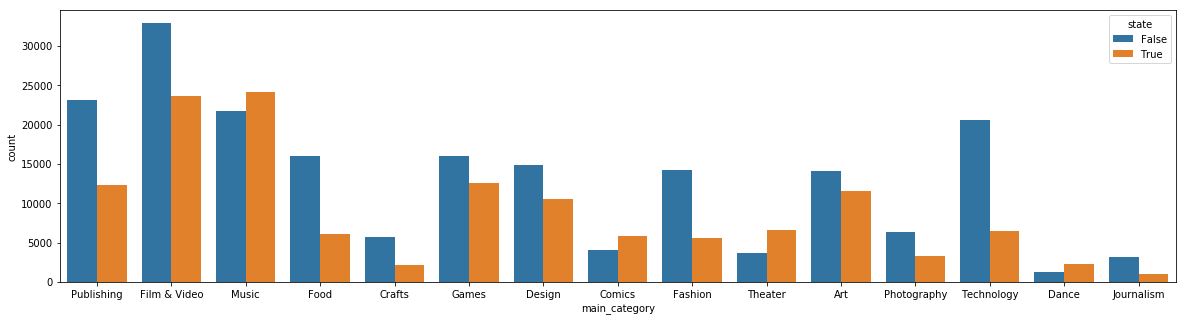

In [12]:
#main_category毎の成功・失敗の確認
plt.figure(figsize=(20,5))
sns.countplot(data=df_c, x='main_category',hue='state')
plt.show()

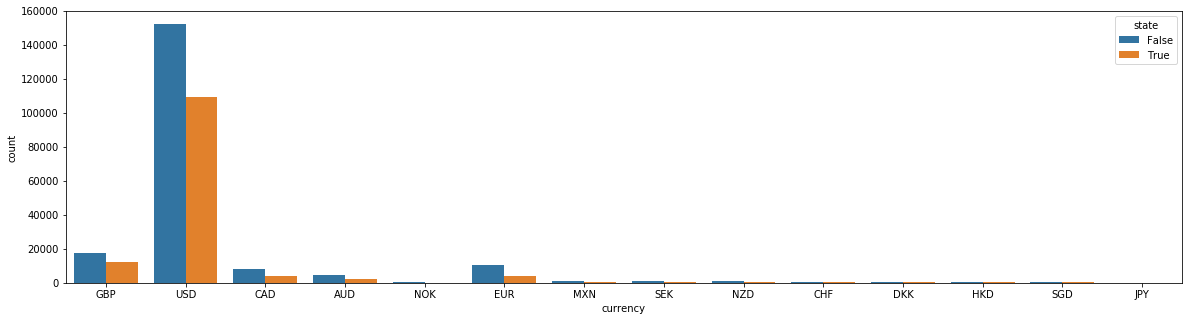

In [13]:
# 通貨毎の成功・失敗の確認
plt.figure(figsize=(20,5))
sns.countplot(data=df_c, x='currency',hue='state') 
plt.show()

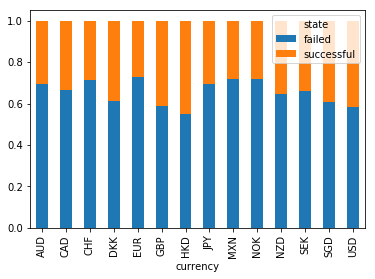

In [14]:
# USDが多すぎてグラフとして成り立たないため正規化して表示
currency_g = pd.crosstab(df_c['currency'],df['state'],normalize='index')
currency_g.plot.bar(stacked=True)

In [16]:
# スケールの大きい変数day_left、usd_goal_realについて情報表示
display(df_c['day_left'].describe())
display(df_c['usd_goal_real'].describe())

count    331675.000000
mean         33.389378
std          12.723385
min           0.005058
25%          29.088929
50%          29.656759
75%          35.705966
max          91.962650
Name: day_left, dtype: float64

count    3.316750e+05
mean     4.151000e+04
std      1.108930e+06
min      1.000000e-02
25%      2.000000e+03
50%      5.000000e+03
75%      1.500000e+04
max      1.663614e+08
Name: usd_goal_real, dtype: float64

In [175]:
# それぞれのmaxとminに近い領域で数値がどれだけあるか確認(正規化できるかの確認のため)
print(len(df_c.query('not day_left < 89')))
print(len(df_c.query('not day_left > 13')))

print(len(df_c.query('not usd_goal_real < 1e+08')))
print(len(df_c.query('not usd_goal_real > 1')))

1767
8592
24
312


In [12]:
# nameの文字列数を数えるためにtypeをstrに変更
df_c['name_str'] = df_c['name'].astype(str)

In [13]:
df_c["name_length"] = df_c["name_str"].apply(lambda x: len(x))
# nameをstrに変換したものの文字数を数えたものをname_length列に入れ表示
df_c.head()

,state,name,currency,main_category,day_left,usd_goal_real,name_str,name_length
0,False,The Songs of Adelaide & Abullah,GBP,Publishing,58.491343,1533.95,The Songs of Adelaide & Abullah,31
1,False,Greeting From Earth: ZGAC Arts Capsule For ET,USD,Film & Video,59.802813,30000.00,Greeting From Earth: ZGAC Arts Capsule For ET,45
2,False,Where is Hank?,USD,Film & Video,44.985532,45000.00,Where is Hank?,14
3,False,ToshiCapital Rekordz Needs Help to Complete Album,USD,Music,29.858206,5000.00,ToshiCapital Rekordz Needs Help to Complete Album,49
5,True,Monarch Espresso Bar,USD,Food,34.431632,50000.00,Monarch Espresso Bar,20


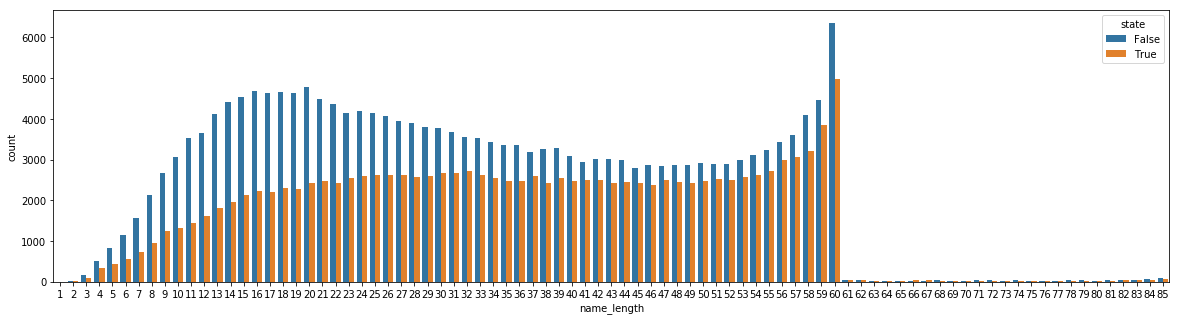

In [17]:
plt.figure(figsize=(20,5))
sns.countplot(data=df_c, x='name_length',hue='state') # main_category毎に成功・失敗があるため説明変数として使用してみる
plt.show()

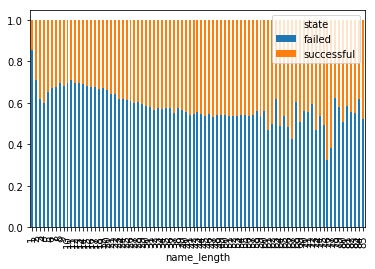

In [18]:
# currencyと同様になっているため100%棒グラフに変更
name_length_g = pd.crosstab(df_c['name_length'],df['state'],normalize='index')
name_length_g.plot.bar(stacked=True)
# 比率はある程度一定のため使用できると判断

In [21]:
# スケールの大きいname_lengthについて情報表示
df_c['name_length'].describe()

count    331675.000000
mean         34.220053
std          15.961706
min           1.000000
25%          21.000000
50%          33.000000
75%          48.000000
max          85.000000
Name: name_length, dtype: float64

In [ ]:
# maxとminに近い領域で数値がどれだけあるか確認
print(len(df_c.query('not name_length < 80')))
print(len(df_c.query('not name_length > 5')))

### ここまでのまとめ
* 説明変数として使えそうなものは、name_length、main_category、currency、usd_goal_real、day_left
* 目的変数はstate (True、Falseに変換済)
* いずれのスケールの大きい説明変数もmaxとminに近い数値がある程度ある、またクラウンドファンディングは最長期間が決まっているので正規化でもよい？
* name_lengthとusd_goal_realは上限が決まっているわけではないので、一旦標準化をベースに進める
* 気になるのはusd_goal_realで0.01がある…が、minに近い領域にそれなりに個数があるため一旦置いておく
* nameにはNaNがあるので、使うのであればdropnaを忘れないように(NaNは４つしかなく全数に対して極小量のためdropしても問題なし)

In [14]:
# name列のnanは全数30万以上に対して4個のため、なくしても影響なしと判断できるため、nanが含まれる行を消す
df_c = df_c.dropna()
df_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331672 entries, 0 to 378660
Data columns (total 8 columns):
state            331672 non-null bool
name             331672 non-null object
currency         331672 non-null object
main_category    331672 non-null object
day_left         331672 non-null float64
usd_goal_real    331672 non-null float64
name_str         331672 non-null object
name_length      331672 non-null int64
dtypes: bool(1), float64(2), int64(1), object(4)
memory usage: 20.6+ MB


In [15]:
df_c = df_c.reindex(columns=['state','name_length','day_left','usd_goal_real'])
df_c.head()

,state,name_length,day_left,usd_goal_real
0,False,31,58.491343,1533.95
1,False,45,59.802813,30000.00
2,False,14,44.985532,45000.00
3,False,49,29.858206,5000.00
5,True,20,34.431632,50000.00


In [16]:
# ２つのデータフレームを結合させる
df_c_a = pd.concat([df_c,df_fs_dummy],axis=1,join_axes=[df_c.index]) 
df_c_all = pd.concat([df_c_a,df_fs_dummy_c],axis=1,join_axes=[df_c_a.index])
# axis=1:列側にて結合。join_axesにdf_cのindexを指定しているのでdf_cのindexが残る
df_c_all.head()

,state,name_length,day_left,usd_goal_real,Art,Comics,Crafts,Dance,Design,Fashion,...,EUR,GBP,HKD,JPY,MXN,NOK,NZD,SEK,SGD,USD
0,False,31,58.491343,1533.95,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,False,45,59.802813,30000.00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,False,14,44.985532,45000.00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,False,49,29.858206,5000.00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,True,20,34.431632,50000.00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### １．ロジスティック回帰(未正則化)+標準化

In [17]:
from sklearn.model_selection import train_test_split, GridSearchCV
y = df_c_all['state'].values
X = df_c_all.drop('state',axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1000)

std_scaler = StandardScaler() 

X_scaled = std_scaler.fit_transform(X_train)
X_scaled_t = std_scaler.transform(X_test)

clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1000, tol=1e-3)
clf.fit(X_scaled, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=10000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='none',
       power_t=0.5, random_state=1000, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [23]:
y_est = clf.predict(X_scaled_t)

y_est_proba = clf.predict_proba(X_test) # 確率値を得る

conf_mat = pd.DataFrame(confusion_matrix(y_test,y_est),
                       index=['正解 = 未達成','正解 = 達成'],
                       columns=['予測 = 未達成','予測 = 達成'])
display(conf_mat)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_est_proba, normalize=False))) 

accuracy = accuracy_score(y_test,y_est)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_est)

print('正答率 = {:.3f}%'.format(100 * accuracy))
print('適合率 = {:.3f}%'.format(100 * precision[0]))
print('再現率 = {:.3f}%'.format(100 * recall[0]))
print('F1値 = {:.3f}'.format(100 * f1_score[0]))

,予測 = 未達成,予測 = 達成
正解 = 未達成,46490,12862
正解 = 達成,21931,18219


対数尤度 = -1385180.904
正答率 = 65.033%
適合率 = 67.947%
再現率 = 78.329%
F1値 = 72.770


In [18]:
# 非線形SVMは計算負荷が大きいのでサンプルを取得する
df_c_sample = df_c_all.sample(n = 50000)
df_c_sample.head()

,state,name_length,day_left,usd_goal_real,Art,Comics,Crafts,Dance,Design,Fashion,...,EUR,GBP,HKD,JPY,MXN,NOK,NZD,SEK,SGD,USD
194575,True,34,29.881389,800.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
71797,True,17,25.649572,10000.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
122441,False,24,29.163738,10000.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
61899,True,54,54.019097,2200.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
161799,True,46,29.413958,10000.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [19]:
from sklearn.model_selection import train_test_split
y1 = df_c_sample['state'].values
X1 = df_c_sample.drop('state',axis=1).values
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=1000)

std_scaler = StandardScaler() 

X1_scaled = std_scaler.fit_transform(X1_train)
X1_scaled_t = std_scaler.transform(X1_test)

# ロジスティック回帰
clf1 = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1000, tol=1e-3)
clf1.fit(X1_scaled, y1_train)

# SVM
clf3 = SGDClassifier(loss='hinge', penalty='none', max_iter=10000, fit_intercept=True, random_state=1000, tol=1e-3)
clf3.fit(X1_scaled, y1_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge',
       max_iter=10000, n_iter=None, n_iter_no_change=5, n_jobs=None,
       penalty='none', power_t=0.5, random_state=1000, shuffle=True,
       tol=0.001, validation_fraction=0.1, verbose=0, warm_start=False)

### 2.サンプル数50000でのロジスティック回帰(未正則化)＋標準化

In [29]:
y1_est = clf.predict(X1_scaled_t)

y1_est_proba = clf.predict_proba(X1_scaled_t)

conf_mat = pd.DataFrame(confusion_matrix(y1_test,y1_est),
                       index=['正解 = 未達成','正解 = 達成'],
                       columns=['予測 = 未達成','予測 = 達成'])
display(conf_mat)

print('対数尤度 = {:.3f}'.format(- log_loss(y1_test, y1_est_proba, normalize=False))) 

accuracy = accuracy_score(y1_test,y1_est)
precision, recall, f1_score, _ = precision_recall_fscore_support(y1_test, y1_est)

print('正答率 = {:.3f}%'.format(100 * accuracy))
print('適合率 = {:.3f}%'.format(100 * precision[0]))
print('再現率 = {:.3f}%'.format(100 * recall[0]))
print('F1値 = {:.3f}'.format(100 * f1_score[0]))

,予測 = 未達成,予測 = 達成
正解 = 未達成,7136,1772
正解 = 達成,3544,2548


対数尤度 = -9405.711
正答率 = 64.560%
適合率 = 66.816%
再現率 = 80.108%
F1値 = 72.861


* 全数での結果とサンプル数50000での結果は大きく変わらないため、サンプル数50000を使用し様々なモデルで検証する。

### 3.サンプル数50000での非線形SVM＋標準化

In [34]:
from sklearn.svm import SVC # 分類
from common_func import plot_decision_regions # 決定領域表示関数
C = 5 
karnel='rbf'
gamma = 'scale' 
clf2 = SVC(C=C, kernel=karnel, gamma=gamma)
clf2.fit(X1_scaled,y1_train)

y2_est = clf2.predict(X1_scaled_t)

conf_mat = pd.DataFrame(confusion_matrix(y1_test,y2_est),
                       index=['正解 = 未達成','正解 = 達成'],
                       columns=['予測 = 未達成','予測 = 達成'])
display(conf_mat)

accuracy = accuracy_score(y1_test,y2_est)
precision, recall, f1_score, _ = precision_recall_fscore_support(y1_test, y2_est)

print('正答率 = {:.3f}%'.format(100 * accuracy))
print('適合率 = {:.3f}%'.format(100 * precision[0]))
print('再現率 = {:.3f}%'.format(100 * recall[0]))
print('F1値 = {:.3f}'.format(100 * f1_score[0]))

,予測 = 未達成,予測 = 達成
正解 = 未達成,7620,1279
正解 = 達成,4170,1931


正答率 = 63.673%
適合率 = 64.631%
再現率 = 85.628%
F1値 = 73.662


### 4.サンプル数50000での線形SVM＋標準化

In [31]:
# サンプル数50000の線形SVM

y3_est = clf3.predict(X1_scaled_t)

conf_mat = pd.DataFrame(confusion_matrix(y1_test,y3_est),
                       index=['正解 = 未達成','正解 = 達成'],
                       columns=['予測 = 未達成','予測 = 達成'])
display(conf_mat) 

accuracy = accuracy_score(y1_test,y3_est)
precision, recall, f1_score, _ = precision_recall_fscore_support(y1_test, y3_est)

print('正答率 = {:.3f}%'.format(100 * accuracy))
print('適合率 = {:.3f}%'.format(100 * precision[0]))
print('再現率 = {:.3f}%'.format(100 * recall[0]))
print('F1値 = {:.3f}'.format(100 * f1_score[0]))

,予測 = 未達成,予測 = 達成
正解 = 未達成,7089,1819
正解 = 達成,3553,2539


正答率 = 64.187%
適合率 = 66.613%
再現率 = 79.580%
F1値 = 72.522


In [26]:
# グリッドサーチのためにサンプル数をさらに絞る
df_c_sample2 = df_c_all.sample(frac = 0.03)
df_c_sample2.head()

,state,name_length,day_left,usd_goal_real,Art,Comics,Crafts,Dance,Design,Fashion,...,EUR,GBP,HKD,JPY,MXN,NOK,NZD,SEK,SGD,USD
184211,False,34,29.905162,500.00,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
224991,True,29,58.240613,6400.00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
232726,True,43,30.020451,2000.00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
52456,False,60,59.872431,20000.00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
233101,False,5,29.051736,2000.00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
163754,True,13,30.332824,10000.00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
126380,True,49,29.670833,20000.00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
373416,True,24,29.148426,700000.00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
218822,True,46,24.823623,3000.00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
180849,True,39,30.249641,12000.00,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


### 非線形SVMの最適パラメータ探索のためのグリッドサーチの実行

In [27]:
y0 = df_c_sample2['state'].values
X0 = df_c_sample2.drop('state',axis=1).values
X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0, test_size=0.3, random_state=1000)
std_scaler = StandardScaler() 

X0_scaled = std_scaler.fit_transform(X0_train)
X0_scaled_t = std_scaler.transform(X0_test)

In [34]:
parameters = {'kernel':['linear','rbf'], 'C':[1,5,10]}
model = SVC(gamma="scale")
clf0 = GridSearchCV(model, parameters, cv=2,)
clf0.fit(X0_scaled, y0_train)
print(clf0.best_params_, clf0.best_score_)

{'C': 1, 'kernel': 'rbf'} 0.6218234027279254


In [35]:
# karnel='rbf'がいいのはわかったため、rbfは固定
# C=5がいいとされているので、前後の範囲を狭める
parameters = {'kernel':['rbf'], 'C':[3,5,7]}
model = SVC(gamma="scale")
clf0 = GridSearchCV(model, parameters, cv=2,)
clf0.fit(X0_scaled, y0_train)
print(clf0.best_params_, clf0.best_score_)

{'C': 3, 'kernel': 'rbf'} 0.6215362526920316


In [36]:
# C=5より7がいいとなっているため、次に7付近で探索
parameters = {'kernel':['rbf'], 'C':[6.5,7,7.5]}
model = SVC(gamma='scale')
clf0 = GridSearchCV(model, parameters, cv=2,)
clf0.fit(X0_scaled, y0_train)
print(clf0.best_params_, clf0.best_score_)

{'C': 7, 'kernel': 'rbf'} 0.6213926776740847


In [37]:
# C=7で合ってそうだが、cvの数を増やしてみる
parameters = {'kernel':['rbf'], 'C':[6.5,7,7.5]}
model = SVC(gamma='scale')
clf0 = GridSearchCV(model, parameters, cv=3,)
clf0.fit(X0_scaled, y0_train)
print(clf0.best_params_, clf0.best_score_)

{'C': 7, 'kernel': 'rbf'} 0.6259870782483847


In [38]:
# C=6.5になったため、再度周辺を確認
parameters = {'kernel':['rbf'], 'C':[6.3,6.5,6.7]}
model = SVC(gamma='scale')
clf0 = GridSearchCV(model, parameters, cv=3,)
clf0.fit(X0_scaled, y0_train)
print(clf0.best_params_, clf0.best_score_)

{'C': 6.3, 'kernel': 'rbf'} 0.6255563531945442


In [39]:
# C=6.3になったため、再度周辺を確認
parameters = {'kernel':['rbf'], 'C':[6,6.2,6.4]}
model = SVC(gamma='scale')
clf0 = GridSearchCV(model, parameters, cv=3,)
clf0.fit(X0_scaled, y0_train)
print(clf0.best_params_, clf0.best_score_)

{'C': 6, 'kernel': 'rbf'} 0.625699928212491


In [40]:
# 6.3 <= C <= 6.44は確定
parameters = {'kernel':['rbf'], 'C':[6.3,6.39,6.44]}
model = SVC(gamma='scale')
clf0 = GridSearchCV(model, parameters, cv=3,)
clf0.fit(X0_scaled, y0_train)
print(clf0.best_params_, clf0.best_score_)

{'C': 6.3, 'kernel': 'rbf'} 0.6255563531945442


### 5.サンプル数50000での非線形SVM＋標準化

In [ ]:
# C=6.39で計算しなおす
C = 6.39 
karnel='rbf'
gamma = 'scale' 
clf2 = SVC(C=C, kernel=karnel, gamma=gamma)
clf2.fit(X1_scaled,y1_train)

y2_est = clf2.predict(X1_scaled_t)

conf_mat = pd.DataFrame(confusion_matrix(y1_test,y2_est),
                       index=['正解 = 未達成','正解 = 達成'],
                       columns=['予測 = 未達成','予測 = 達成'])
display(conf_mat)

accuracy = accuracy_score(y1_test,y2_est)
precision, recall, f1_score, _ = precision_recall_fscore_support(y1_test, y2_est)

print('正答率 = {:.3f}%'.format(100 * accuracy))
print('適合率 = {:.3f}%'.format(100 * precision[0]))
print('再現率 = {:.3f}%'.format(100 * recall[0]))
print('F1値 = {:.3f}'.format(100 * f1_score[0]))

,予測 = 未達成,予測 = 達成
正解 = 未達成,7394,1514
正解 = 達成,3975,2117


正答率 = 63.407%
適合率 = 65.037%
再現率 = 83.004%
F1値 = 72.930


* X,y：全数の訓練データ、テストデータ・X1,y1：サンプル数50000の訓練データ、テストデータ
* 3と5の結果を比べてもそんなに大きな変化は見られない。

### 6.サンプル数50000のロジスティック回帰(L2正則化)

In [ ]:
clf6 = SGDClassifier(loss='log', penalty='L2', max_iter=10000, fit_intercept=True, random_state=1000, tol=1e-5)
clf6.fit(X1_scaled, y1_train)

y6_est = clf6.predict(X1_scaled_t)

y6_est_proba = clf6.predict_proba(X1_scaled_t)

conf_mat = pd.DataFrame(confusion_matrix(y1_test,y6_est),
                       index=['正解 = 未達成','正解 = 達成'],
                       columns=['予測 = 未達成','予測 = 達成'])
display(conf_mat)

accuracy = accuracy_score(y1_test,y6_est)
precision, recall, f1_score, _ = precision_recall_fscore_support(y1_test, y6_est)

print('正答率 = {:.3f}%'.format(100 * accuracy))
print('適合率 = {:.3f}%'.format(100 * precision[0]))
print('再現率 = {:.3f}%'.format(100 * recall[0]))
print('F1値 = {:.3f}'.format(100 * f1_score[0]))

,予測 = 未達成,予測 = 達成
正解 = 未達成,6996,1912
正解 = 達成,3553,2539


正答率 = 63.567%
適合率 = 66.319%
再現率 = 78.536%
F1値 = 71.912


### 7.サンプル数50000のロジスティック回帰(L1正則化)

In [ ]:
clf7 = SGDClassifier(loss='log', penalty='L1', max_iter=10000, fit_intercept=True, random_state=1000, tol=1e-5)
clf7.fit(X1_scaled, y1_train)

y7_est = clf7.predict(X1_scaled_t)

y7_est_proba = clf7.predict_proba(X1_scaled_t)

conf_mat = pd.DataFrame(confusion_matrix(y1_test,y7_est),
                       index=['正解 = 未達成','正解 = 達成'],
                       columns=['予測 = 未達成','予測 = 達成'])
display(conf_mat)

accuracy = accuracy_score(y1_test,y7_est)
precision, recall, f1_score, _ = precision_recall_fscore_support(y1_test, y7_est)

print('正答率 = {:.3f}%'.format(100 * accuracy))
print('適合率 = {:.3f}%'.format(100 * precision[0]))
print('再現率 = {:.3f}%'.format(100 * recall[0]))
print('F1値 = {:.3f}'.format(100 * f1_score[0]))

,予測 = 未達成,予測 = 達成
正解 = 未達成,7054,1854
正解 = 達成,3477,2615


正答率 = 64.460%
適合率 = 66.983%
再現率 = 79.187%
F1値 = 72.576


### 8.サンプル数50000のロジスティック回帰(Elasticnet(L1正則化の強さは0.7を採用))：0.7が最も正答率が高かったため

In [ ]:
clf8 = SGDClassifier(loss='log', penalty='Elasticnet',l1_ratio=0.7, max_iter=10000, fit_intercept=True, random_state=1000, tol=1e-5)
clf8.fit(X1_scaled, y1_train)

y8_est = clf8.predict(X1_scaled_t)

y8_est_proba = clf8.predict_proba(X1_scaled_t)

conf_mat = pd.DataFrame(confusion_matrix(y1_test,y8_est),
                       index=['正解 = 未達成','正解 = 達成'],
                       columns=['予測 = 未達成','予測 = 達成'])
display(conf_mat)


accuracy = accuracy_score(y1_test,y8_est)
precision, recall, f1_score, _ = precision_recall_fscore_support(y1_test, y8_est)

print('正答率 = {:.3f}%'.format(100 * accuracy))
print('適合率 = {:.3f}%'.format(100 * precision[0]))
print('再現率 = {:.3f}%'.format(100 * recall[0]))
print('F1値 = {:.3f}'.format(100 * f1_score[0]))

,予測 = 未達成,予測 = 達成
正解 = 未達成,7254,1654
正解 = 達成,3715,2377


正答率 = 64.207%
適合率 = 66.132%
再現率 = 81.432%
F1値 = 72.989


### 9.サンプル数50000の決定木モデル

In [28]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
clf9 = DecisionTreeClassifier(criterion="gini", max_depth=None, min_samples_split=2, min_samples_leaf=2, random_state=1000)
clf9 = clf9.fit(X1_scaled, y1_train)

y9_est = clf9.predict(X1_scaled_t)

conf_mat = pd.DataFrame(confusion_matrix(y1_test,y9_est),
                       index=['正解 = 未達成','正解 = 達成'],
                       columns=['予測 = 未達成','予測 = 達成'])
display(conf_mat)


accuracy = accuracy_score(y1_test,y9_est)
precision, recall, f1_score, _ = precision_recall_fscore_support(y1_test, y9_est)

print('正答率 = {:.3f}%'.format(100 * accuracy))
print('適合率 = {:.3f}%'.format(100 * precision[0]))
print('再現率 = {:.3f}%'.format(100 * recall[0]))

,予測 = 未達成,予測 = 達成
正解 = 未達成,6437,2462
正解 = 達成,3468,2633


正答率 = 60.467%
適合率 = 64.987%
再現率 = 72.334%


### 10.サンプル数50000でのランダムフォレスト

In [29]:
from sklearn.ensemble import RandomForestClassifier
clf10 = RandomForestClassifier(n_estimators=300, max_depth=20, criterion="gini",
                                                 min_samples_leaf=6, min_samples_split=6, random_state=1000)
clf10.fit(X1_scaled, y1_train)
y10_est = clf10.predict(X1_scaled_t)

y10_est_proba = clf10.predict_proba(X1_scaled_t)

conf_mat = pd.DataFrame(confusion_matrix(y1_test,y10_est),
                       index=['正解 = 未達成','正解 = 達成'],
                       columns=['予測 = 未達成','予測 = 達成'])
display(conf_mat)

accuracy = accuracy_score(y1_test,y10_est)
precision, recall, f1_score, _ = precision_recall_fscore_support(y1_test, y10_est)

print('正答率 = {:.3f}%'.format(100 * accuracy))
print('適合率 = {:.3f}%'.format(100 * precision[0]))
print('再現率 = {:.3f}%'.format(100 * recall[0]))
#print('F1値 = {:.3f}'.format(100 * f1_score[0])

,予測 = 未達成,予測 = 達成
正解 = 未達成,7276,1623
正解 = 達成,3429,2672


正答率 = 66.320%
適合率 = 67.968%
再現率 = 81.762%


In [ ]:
#pip install optuna

Note: you may need to restart the kernel to use updated packages.


### 11.サンプル数50000のアダブースト(決定木使用モデル)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

clf11 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=30, min_samples_leaf=6,min_samples_split=6, random_state=1000,criterion="gini"),
                                           n_estimators=30 , random_state=1000) 
clf11.fit(X1_scaled, y1_train)

y11_est = clf11.predict(X1_scaled_t)

y11_est_proba = clf11.predict_proba(X1_scaled_t)

conf_mat = pd.DataFrame(confusion_matrix(y1_test,y11_est),
                       index=['正解 = 未達成','正解 = 達成'],
                       columns=['予測 = 未達成','予測 = 達成'])
display(conf_mat)

accuracy = accuracy_score(y1_test,y11_est)
precision, recall, f1_score, _ = precision_recall_fscore_support(y1_test, y11_est)

print('正答率 = {:.3f}%'.format(100 * accuracy))
print('適合率 = {:.3f}%'.format(100 * precision[0]))
print('再現率 = {:.3f}%'.format(100 * recall[0]))

,予測 = 未達成,予測 = 達成
正解 = 未達成,6162,2746
正解 = 達成,3122,2970


正答率 = 60.880%
適合率 = 66.372%
再現率 = 69.174%


### 12.サンプル数50000のアダブースト(ロジスティック回帰(L1正則化使用)

In [ ]:
clf12 = AdaBoostClassifier(SGDClassifier(loss='log', penalty='l1', max_iter=10000, fit_intercept=True, random_state=1000, tol=1e-5),
                                           n_estimators=10 , random_state=1000)
clf12.fit(X1_scaled, y1_train)

y12_est = clf12.predict(X1_scaled_t)

y12_est_proba = clf12.predict_proba(X1_scaled_t)

conf_mat = pd.DataFrame(confusion_matrix(y1_test,y12_est),
                       index=['正解 = 未達成','正解 = 達成'],
                       columns=['予測 = 未達成','予測 = 達成'])
display(conf_mat)

accuracy = accuracy_score(y1_test,y12_est)
precision, recall, f1_score, _ = precision_recall_fscore_support(y1_test, y12_est)

print('正答率 = {:.3f}%'.format(100 * accuracy))
print('適合率 = {:.3f}%'.format(100 * precision[0]))
print('再現率 = {:.3f}%'.format(100 * recall[0]))

,予測 = 未達成,予測 = 達成
正解 = 未達成,8908,0
正解 = 達成,6092,0


正答率 = 59.387%
適合率 = 59.387%
再現率 = 100.000%


C:\Users\t104950\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### ここまでのまとめ
* 条件は、サンプル数50000(ランダムサンプリング)、ホールドアウト法を使用する場合は学習7割・テスト3割とする。
* それぞれの項目で最も高いのは
* Accuracy(正答率) ：ランダムフォレスト使用で66.690％
* Precision(適合率)：ロジスティック回帰(L1正則化)＋標準化使用で69.640％
* Recall(再現率)　 ：非線形SVM使用で84.459%
* となっている。再現率はモデルによって差が大きいので、そちらが重視される場合は注意が必要。

### 検証：特徴選択
* 次に、特徴選択を自動で行い、何種類かのモデルで正答率の変化を確認する。

In [54]:
# 列毎の型の確認
df_crowd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


In [55]:
df_crowd_sf =  df_crowd[(df_crowd['state'] == 'successful') | (df_crowd['state'] =='failed')]
df_crowd_sf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331675 entries, 0 to 378660
Data columns (total 15 columns):
ID                  331675 non-null int64
name                331672 non-null object
category            331675 non-null object
main_category       331675 non-null object
currency            331675 non-null object
deadline            331675 non-null object
goal                331675 non-null float64
launched            331675 non-null object
pledged             331675 non-null float64
state               331675 non-null object
backers             331675 non-null int64
country             331675 non-null object
usd pledged         331465 non-null float64
usd_pledged_real    331675 non-null float64
usd_goal_real       331675 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 40.5+ MB


In [56]:
# ダミー変数データと合体させられるよう行を揃える。
df_crowd_sf_d = df_crowd_sf.dropna(subset=['name'])

In [57]:
df_crowd_sf_d['deadline'] = pd.to_datetime(df_crowd_sf_d['deadline'])

C:\Users\t104950\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [58]:
df_crowd_sf_d['launched'] = pd.to_datetime(df_crowd_sf_d['launched'])

C:\Users\t104950\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [59]:
# オブジェクトを除外
df_crowd_d = df_crowd_sf_d.select_dtypes(exclude='object')
df_crowd_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331672 entries, 0 to 378660
Data columns (total 9 columns):
ID                  331672 non-null int64
deadline            331672 non-null datetime64[ns]
goal                331672 non-null float64
launched            331672 non-null datetime64[ns]
pledged             331672 non-null float64
backers             331672 non-null int64
usd pledged         331462 non-null float64
usd_pledged_real    331672 non-null float64
usd_goal_real       331672 non-null float64
dtypes: datetime64[ns](2), float64(5), int64(2)
memory usage: 25.3 MB


In [60]:
df_crowd_n = df_crowd_d[['ID','goal']]

In [61]:
# オブジェクトと終了後に得られるデータを除いたもののデータベースを作る
df_crowd_na = pd.concat([df_c,df_crowd_n],axis=1,join_axes=[df_c.index])
df_crowd_na.head()

,state,name_length,day_left,usd_goal_real,ID,goal
0,False,31,58.491343,1533.95,1000002330,1000.0
1,False,45,59.802813,30000.00,1000003930,30000.0
2,False,14,44.985532,45000.00,1000004038,45000.0
3,False,49,29.858206,5000.00,1000007540,5000.0
5,True,20,34.431632,50000.00,1000014025,50000.0


In [62]:
# 特徴選択の実行

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

estimator = LassoCV(normalize=True, cv=10)

sfm = SelectFromModel(estimator, threshold=1e-5)

train_label = df_crowd_na["state"]
train_data = df_crowd_na.drop("state", axis=1)

y = train_label.values
X = train_data.values

sfm.fit(X, y)

SelectFromModel(estimator=LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=True,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False),
        max_features=None, norm_order=1, prefit=False, threshold=1e-05)

In [63]:
sfm.get_support()

array([ True,  True, False, False, False])

In [64]:
removed_idx  = ~sfm.get_support()
train_data.columns[removed_idx]

Index(['usd_goal_real', 'ID', 'goal'], dtype='object')

In [68]:
# 選択された特徴のみ取り出す
df_crowd_nas = df_crowd_na[['state','name_length','day_left']]
df_crowd_nas.head()

,state,name_length,day_left
0,False,31,58.491343
1,False,45,59.802813
2,False,14,44.985532
3,False,49,29.858206
5,True,20,34.431632


In [69]:
# ダミー変数データと合体させる
df_crowd_a = pd.concat([df_crowd_nas,df_fs_dummy],axis=1,join_axes=[df_crowd_nas.index]) 
df_crowd_all = pd.concat([df_crowd_a,df_fs_dummy_c],axis=1,join_axes=[df_crowd_a.index])
df_crowd_all.head()

,state,name_length,day_left,Art,Comics,Crafts,Dance,Design,Fashion,Film & Video,...,EUR,GBP,HKD,JPY,MXN,NOK,NZD,SEK,SGD,USD
0,False,31,58.491343,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,False,45,59.802813,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,False,14,44.985532,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,False,49,29.858206,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,True,20,34.431632,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [70]:
# 非線形SVMは計算負荷が大きいのでサンプルを取得する
df_crowd_sample = df_crowd_all.sample(n = 50000)

### 特徴選択された説明変数でロジスティック回帰、SVMを実行)

In [71]:
y20 = df_crowd_sample['state'].values
X20 = df_crowd_sample.drop('state',axis=1).values
X20_train, X20_test, y20_train, y20_test = train_test_split(X20, y20, test_size=0.3, random_state=1000)

std_scaler = StandardScaler() 

X20_scaled = std_scaler.fit_transform(X20_train)
X20_scaled_t = std_scaler.transform(X20_test)

# ロジスティック回帰
clf20 = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1000, tol=1e-3)
clf20.fit(X20_scaled, y20_train)

# SVM
clf21 = SGDClassifier(loss='hinge', penalty='none', max_iter=10000, fit_intercept=True, random_state=1000, tol=1e-3)
clf21.fit(X20_scaled, y20_train)

# ロジスティック回帰(Elasticnetにて正則化)
clf22 = SGDClassifier(loss='log', penalty='l1', max_iter=10000, fit_intercept=True, random_state=1000, tol=1e-5)
clf22.fit(X20_scaled, y20_train)

#SVM(Elasticnetにて正則化)
clf23 = SGDClassifier(loss='hinge', penalty='Elasticnet',l1_ratio=0.7, max_iter=10000, fit_intercept=True, random_state=1000, tol=1e-5)
clf23.fit(X20_scaled, y20_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.7, learning_rate='optimal', loss='hinge', max_iter=10000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='Elasticnet',
       power_t=0.5, random_state=1000, shuffle=True, tol=1e-05,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [72]:
# ロジスティック回帰
y20_est = clf20.predict(X20_scaled_t)

y20_est_proba = clf20.predict_proba(X20_scaled_t)

conf_mat = pd.DataFrame(confusion_matrix(y20_test,y20_est),
                       index=['正解 = 未達成','正解 = 達成'],
                       columns=['予測 = 未達成','予測 = 達成'])
display(conf_mat)

print('対数尤度 = {:.3f}'.format(- log_loss(y20_test, y20_est_proba, normalize=False))) 

accuracy = accuracy_score(y20_test,y20_est)
precision, recall, f1_score, _ = precision_recall_fscore_support(y20_test, y20_est)

print('正答率 = {:.3f}%'.format(100 * accuracy))
print('適合率 = {:.3f}%'.format(100 * precision[0]))
print('再現率 = {:.3f}%'.format(100 * recall[0]))
print('F1値 = {:.3f}'.format(100 * f1_score[0]))

,予測 = 未達成,予測 = 達成
正解 = 未達成,7598,1331
正解 = 達成,4190,1881


対数尤度 = -9810.564
正答率 = 63.193%
適合率 = 64.455%
再現率 = 85.094%
F1値 = 73.350


In [73]:
# SVM
y21_est = clf21.predict(X20_scaled_t)

conf_mat = pd.DataFrame(confusion_matrix(y20_test,y21_est),
                       index=['正解 = 未達成','正解 = 達成'],
                       columns=['予測 = 未達成','予測 = 達成'])
display(conf_mat)

accuracy = accuracy_score(y20_test,y21_est)
precision, recall, f1_score, _ = precision_recall_fscore_support(y20_test, y21_est)

print('正答率 = {:.3f}%'.format(100 * accuracy))
print('適合率 = {:.3f}%'.format(100 * precision[0]))
print('再現率 = {:.3f}%'.format(100 * recall[0]))
print('F1値 = {:.3f}'.format(100 * f1_score[0]))

,予測 = 未達成,予測 = 達成
正解 = 未達成,7501,1428
正解 = 達成,4303,1768


正答率 = 61.793%
適合率 = 63.546%
再現率 = 84.007%
F1値 = 72.358


In [74]:
# ロジスティック回帰(L1正則化)
y22_est = clf22.predict(X20_scaled_t)

conf_mat = pd.DataFrame(confusion_matrix(y20_test,y22_est),
                       index=['正解 = 未達成','正解 = 達成'],
                       columns=['予測 = 未達成','予測 = 達成'])
display(conf_mat)

accuracy = accuracy_score(y20_test,y22_est)
precision, recall, f1_score, _ = precision_recall_fscore_support(y20_test, y22_est)

print('正答率 = {:.3f}%'.format(100 * accuracy))
print('適合率 = {:.3f}%'.format(100 * precision[0]))
print('再現率 = {:.3f}%'.format(100 * recall[0]))
print('F1値 = {:.3f}'.format(100 * f1_score[0]))

,予測 = 未達成,予測 = 達成
正解 = 未達成,7375,1554
正解 = 達成,3898,2173


正答率 = 63.653%
適合率 = 65.422%
再現率 = 82.596%
F1値 = 73.013


In [75]:
# SVM(L1正則化)
y23_est = clf23.predict(X20_scaled_t)

conf_mat = pd.DataFrame(confusion_matrix(y20_test,y23_est),
                       index=['正解 = 未達成','正解 = 達成'],
                       columns=['予測 = 未達成','予測 = 達成'])
display(conf_mat)

accuracy = accuracy_score(y20_test,y23_est)
precision, recall, f1_score, _ = precision_recall_fscore_support(y20_test, y23_est)

print('正答率 = {:.3f}%'.format(100 * accuracy))
print('適合率 = {:.3f}%'.format(100 * precision[0]))
print('再現率 = {:.3f}%'.format(100 * recall[0]))
print('F1値 = {:.3f}'.format(100 * f1_score[0]))

,予測 = 未達成,予測 = 達成
正解 = 未達成,7543,1386
正解 = 達成,4330,1741


正答率 = 61.893%
適合率 = 63.531%
再現率 = 84.478%
F1値 = 72.522


### 検証：特徴選択　結果
* ロジスティック回帰、SVMを行った結果、先に行っていた自分で特徴選択を行ったものより結果がよくなることはなかった。

### 13．ニューラルネットワークを使用

In [29]:
from tensorflow.keras.utils import to_categorical
y00_train = to_categorical(y1_train)
y00_test = to_categorical(y1_test)

In [43]:
from tensorflow.compat.v1.keras import Sequential
from tensorflow.compat.v1.keras.layers import Dense, Dropout, Activation
from tensorflow.compat.v1.keras.optimizers import SGD,RMSprop, Adagrad, Adadelta, Adam

model = Sequential()
model.add(Dense(15,activation='relu', input_dim=32)) 
model.add(Dense(8,activation='relu'))
model.add(Dense(6, activation='relu'))
model.add(Dense(2, activation='softmax'))

adam = Adam(lr=0.01)

model.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy']) 



Train on 35000 samples, validate on 15000 samples
Epoch 1/20
35000/35000 [==============================] - 1s 35us/sample - loss: 0.6409 - acc: 0.6315 - val_loss: 0.6340 - val_acc: 0.6345
Epoch 2/20
35000/35000 [==============================] - 1s 33us/sample - loss: 0.6328 - acc: 0.6381 - val_loss: 0.6314 - val_acc: 0.6405
Epoch 3/20
35000/35000 [==============================] - 1s 31us/sample - loss: 0.6289 - acc: 0.6426 - val_loss: 0.6291 - val_acc: 0.6369
Epoch 4/20
35000/35000 [==============================] - 1s 30us/sample - loss: 0.6263 - acc: 0.6434 - val_loss: 0.6308 - val_acc: 0.6407
Epoch 5/20
35000/35000 [==============================] - 1s 31us/sample - loss: 0.6256 - acc: 0.6457 - val_loss: 0.6272 - val_acc: 0.6416
Epoch 6/20
35000/35000 [==============================] - 1s 30us/sample - loss: 0.6246 - acc: 0.6442 - val_loss: 0.6318 - val_acc: 0.6193
Epoch 7/20
35000/35000 [==============================] - 1s 30us/sample - loss: 0.6236 - acc: 0.6439 - val_loss: 0.

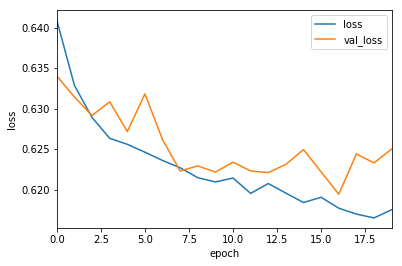

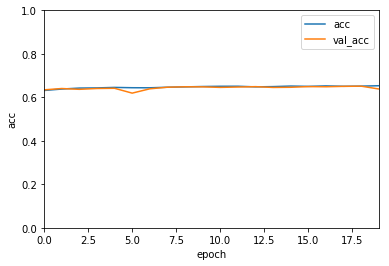

In [44]:
# 計算の実行
X00_train = std_scaler.fit_transform(X1_train)
X00_test = std_scaler.transform(X1_test)

fit = model.fit(X00_train, y00_train,
          epochs=20,
          batch_size=50,validation_data=(X00_test, y00_test))

df = pd.DataFrame(fit.history)

df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

df[["acc", "val_acc"]].plot()
plt.ylabel("acc")
plt.xlabel("epoch")
plt.ylim([0,1.0])
plt.show()

* 層数、ノード数、バッチサイズ等を変えてみたが、正答率に大きな差はなく、いずれも65%程度で推移していた。

### 14．アンサンブル学習(ロジスティック回帰(L1正則化)+決定木+非線形SVM(L1正則化)

In [20]:
X2_train_val, X2_meta_val, y2_train_val, y2_meta_val = train_test_split(X, y, test_size = 0.3, random_state=1000)

In [21]:
X2_train, X2_val, y2_train, y2_val = train_test_split(X2_train_val, y2_train_val, test_size = 0.5, random_state=1000)

In [24]:
std_scaler = StandardScaler() 

X2_std_t = std_scaler.fit_transform(X2_train)
X2_std_mv = std_scaler.transform(X2_meta_val)
X2_std_tv = std_scaler.fit_transform(X2_train_val)
X2_std_v = std_scaler.transform(X2_val)

# ベースとなるモデルを決める
base_model_1 = SGDClassifier(loss='log', penalty='L1', max_iter=6000, fit_intercept=True, random_state=1000, tol=1e-5)
#base_model_2 = SVC(C=48, kernel='rbf', gamma=0.166)
base_model_3 = DecisionTreeClassifier(criterion="entropy", max_depth=58, min_samples_split=9, min_samples_leaf=62, random_state=1000)
# それぞれのモデルで学習
base_model_1.fit(X2_std_t, y2_train)
#base_model_2.fit(X2_std_t, y2_train)
base_model_3.fit(X2_std_t, y2_train)
#SGDClassifier(loss='hinge', penalty='L1', max_iter=6000, fit_intercept=True, random_state=1000, tol=1e-5)

# それぞれのモデルの結果を出力
base_pred_1 = base_model_1.predict(X2_std_v)
#base_pred_2 = base_model_2.predict(X2_std_v)
base_pred_3 = base_model_3.predict(X2_std_v)

In [25]:
val_pred_1 = base_model_1.predict(X2_std_mv)
#val_pred_2 = base_model_2.predict(X2_std_mv)
val_pred_3 = base_model_3.predict(X2_std_mv)
# メタモデルのテストデータの生成
stacked_valid_predictions = np.column_stack((val_pred_1, val_pred_3))

# メタモデルの学習モデルの生成
stacked_predictions = np.column_stack((base_pred_1, base_pred_3))

# 3つのモデルの学習結果を統括して学習 
meta_model =  SVC(C=48, kernel='rbf', gamma=0.166)
meta_model.fit(stacked_predictions, y2_val)

meta_val_pred = meta_model.predict(stacked_valid_predictions)

accuracy1 = accuracy_score(y2_meta_val,val_pred_1)
precision1, recall1, f1_score1, _ = precision_recall_fscore_support(y2_meta_val,val_pred_1)

#accuracy2 = accuracy_score(y2_meta_val,val_pred_2)
#precision2, recall2, f1_score2, _ = precision_recall_fscore_support(y2_meta_val,val_pred_2)

accuracy3 = accuracy_score(y2_meta_val,val_pred_3)
precision3, recall3, f1_score3, _ = precision_recall_fscore_support(y2_meta_val,val_pred_3)

accuracy4 = accuracy_score(y2_meta_val,meta_val_pred)
precision4, recall4, f1_score4, _ = precision_recall_fscore_support(y2_meta_val,meta_val_pred)

print('model1')
print('正答率 = {:.3f}%'.format(100 * accuracy1))
print('適合率 = {:.3f}%'.format(100 * precision1[0]))
print('再現率 = {:.3f}%'.format(100 * recall1[0]))
print('F1値 = {:.3f}'.format(100 * f1_score1[0]))

#print('正答率 = {:.3f}%'.format(100 * accuracy2))
#print('適合率 = {:.3f}%'.format(100 * precision2[0]))
#print('再現率 = {:.3f}%'.format(100 * recall2[0]))
#print('F1値 = {:.3f}'.format(100 * f1_score2[0]))
print('model2')
print('正答率 = {:.3f}%'.format(100 * accuracy3))
print('適合率 = {:.3f}%'.format(100 * precision3[0]))
print('再現率 = {:.3f}%'.format(100 * recall3[0]))
print('F1値 = {:.3f}'.format(100 * f1_score3[0]))
print('meta_model')
print('正答率 = {:.3f}%'.format(100 * accuracy4))
print('適合率 = {:.3f}%'.format(100 * precision4[0]))
print('再現率 = {:.3f}%'.format(100 * recall4[0]))
print('F1値 = {:.3f}'.format(100 * f1_score4[0]))

model1
正答率 = 64.869%
適合率 = 67.288%
再現率 = 79.991%
F1値 = 73.092
model2
正答率 = 65.385%
適合率 = 68.640%
再現率 = 77.271%
F1値 = 72.700
meta_model
正答率 = 65.385%
適合率 = 68.640%
再現率 = 77.271%
F1値 = 72.700


### 15．ハイパーパラメータ探索+非線形SVM

In [30]:
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_validate
def objective(trial):
    params = {
        'kernel': trial.suggest_categorical('kernel',['rbf','sigmoid']),
        'C':trial.suggest_int('C',1,50),
        'gamma':trial.suggest_uniform('gamma',0.01,5),
    }
    model_svc = SVC(**params)
    model_svc.fit(X1_scaled,y1_train)
    return 1.0-accuracy_score(y1_test,model_svc.predict(X1_scaled_t))

if __name__ == '__main__':
    study = optuna.create_study()
    study.optimize(objective,n_trials=10)

print(study.best_params)

[I 2020-10-19 23:12:40,136] A new study created in memory with name: no-name-b974f318-f9d1-4d58-8183-8e2d61596e87
[I 2020-10-19 23:15:13,843] Trial 0 finished with value: 0.4619333333333333 and parameters: {'kernel': 'sigmoid', 'C': 39, 'gamma': 4.211878689384743}. Best is trial 0 with value: 0.4619333333333333.
[I 2020-10-19 23:19:49,103] Trial 1 finished with value: 0.36773333333333336 and parameters: {'kernel': 'rbf', 'C': 15, 'gamma': 2.219538956821322}. Best is trial 1 with value: 0.36773333333333336.
[I 2020-10-19 23:23:24,918] Trial 2 finished with value: 0.3651333333333333 and parameters: {'kernel': 'rbf', 'C': 3, 'gamma': 2.7965592259573353}. Best is trial 2 with value: 0.3651333333333333.
[I 2020-10-19 23:27:35,805] Trial 3 finished with value: 0.36240000000000006 and parameters: {'kernel': 'rbf', 'C': 25, 'gamma': 0.8406007632203557}. Best is trial 3 with value: 0.36240000000000006.
[I 2020-10-19 23:32:56,844] Trial 4 finished with value: 0.3692 and parameters: {'kernel': 'r

{'kernel': 'rbf', 'C': 48, 'gamma': 0.16620824619228955}


In [31]:
C = 48
karnel='rbf'
gamma = 0.166
clf2 = SVC(C=C, kernel=karnel, gamma=gamma)
clf2.fit(X1_scaled,y1_train)

y2_est = clf2.predict(X1_scaled_t)

conf_mat = pd.DataFrame(confusion_matrix(y1_test,y2_est),
                       index=['正解 = 未達成','正解 = 達成'],
                       columns=['予測 = 未達成','予測 = 達成'])
display(conf_mat)

accuracy = accuracy_score(y1_test,y2_est)
precision, recall, f1_score, _ = precision_recall_fscore_support(y1_test, y2_est)

print('正答率 = {:.3f}%'.format(100 * accuracy))
print('適合率 = {:.3f}%'.format(100 * precision[0]))
print('再現率 = {:.3f}%'.format(100 * recall[0]))
print('F1値 = {:.3f}'.format(100 * f1_score[0]))

,予測 = 未達成,予測 = 達成
正解 = 未達成,7320,1653
正解 = 達成,3686,2341


正答率 = 64.407%
適合率 = 66.509%
再現率 = 81.578%
F1値 = 73.277


### 16．ハイパーパラメータ探索使用＋決定木

In [79]:
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth',2,200),
        'min_samples_split':trial.suggest_int('min_samples_split',2,20),
        'min_samples_leaf':trial.suggest_int('min_samples_leaf',2,70),
        'criterion':trial.suggest_categorical('criterion',['gini','entropy'])
    }
    model_dtc = DecisionTreeClassifier(**params)
    model_dtc.fit(X1_scaled,y1_train)
    return 1.0-accuracy_score(y1_test,model_dtc.predict(X1_scaled_t))

if __name__ == '__main__':
    study = optuna.create_study()
    study.optimize(objective,n_trials=50)

print(study.best_params)

[I 2020-10-19 22:48:00,380] A new study created in memory with name: no-name-7e67650b-28fd-4f04-aa1b-d2dfb02643fa
[I 2020-10-19 22:48:00,612] Trial 0 finished with value: 0.369 and parameters: {'max_depth': 33, 'min_samples_split': 9, 'min_samples_leaf': 40, 'criterion': 'gini'}. Best is trial 0 with value: 0.369.
[I 2020-10-19 22:48:00,828] Trial 1 finished with value: 0.36926666666666663 and parameters: {'max_depth': 29, 'min_samples_split': 10, 'min_samples_leaf': 41, 'criterion': 'gini'}. Best is trial 0 with value: 0.369.
[I 2020-10-19 22:48:01,194] Trial 2 finished with value: 0.37706666666666666 and parameters: {'max_depth': 163, 'min_samples_split': 15, 'min_samples_leaf': 11, 'criterion': 'entropy'}. Best is trial 0 with value: 0.369.
[I 2020-10-19 22:48:01,440] Trial 3 finished with value: 0.3733333333333333 and parameters: {'max_depth': 67, 'min_samples_split': 7, 'min_samples_leaf': 21, 'criterion': 'gini'}. Best is trial 0 with value: 0.369.
[I 2020-10-19 22:48:01,656] Tri

{'max_depth': 58, 'min_samples_split': 9, 'min_samples_leaf': 62, 'criterion': 'entropy'}


In [80]:
clf30 = DecisionTreeClassifier(criterion="entropy", max_depth=58, min_samples_split=9, min_samples_leaf=62, random_state=1000)
clf30 = clf30.fit(X1_scaled, y1_train)

y30_est = clf30.predict(X1_scaled_t)

conf_mat = pd.DataFrame(confusion_matrix(y1_test,y30_est),
                       index=['正解 = 未達成','正解 = 達成'],
                       columns=['予測 = 未達成','予測 = 達成'])
display(conf_mat)


accuracy = accuracy_score(y1_test,y30_est)
precision, recall, f1_score, _ = precision_recall_fscore_support(y1_test, y30_est)

print('正答率 = {:.3f}%'.format(100 * accuracy))
print('適合率 = {:.3f}%'.format(100 * precision[0]))
print('再現率 = {:.3f}%'.format(100 * recall[0]))

,予測 = 未達成,予測 = 達成
正解 = 未達成,6846,2053
正解 = 達成,3215,2886


正答率 = 64.880%
適合率 = 68.045%
再現率 = 76.930%


### 17．ハイパーパラメータ探索+ランダムフォレスト

In [32]:
# giniもentropyも結果に変化があまりないので、計算負荷を少なくするためginiで固定する。
def objective(trial):
    params = {
        'n_estimators':trial.suggest_int('n_estimators',100,1000),
         'max_depth': trial.suggest_int('max_depth',2,100),
        'min_samples_split':trial.suggest_int('min_samples_split',2,20),
        'min_samples_leaf':trial.suggest_int('min_samples_leaf',2,50),
        'criterion':trial.suggest_categorical('criterion',['gini'])
    }
    model = RandomForestClassifier(**params)
    model.fit(X1_scaled,y1_train)
    return 1.0-accuracy_score(y1_test,model.predict(X1_scaled_t))

if __name__ == '__main__':
    study = optuna.create_study()
    study.optimize(objective,n_trials=50)

print(study.best_params)

[I 2020-10-20 07:59:33,037] A new study created in memory with name: no-name-06ec4622-0700-49a1-b8ed-8b5dbb9a22a3
[I 2020-10-20 07:59:43,860] Trial 0 finished with value: 0.33199999999999996 and parameters: {'n_estimators': 292, 'max_depth': 39, 'min_samples_split': 16, 'min_samples_leaf': 28, 'criterion': 'gini'}. Best is trial 0 with value: 0.33199999999999996.
[I 2020-10-20 08:00:07,769] Trial 1 finished with value: 0.3349333333333333 and parameters: {'n_estimators': 409, 'max_depth': 76, 'min_samples_split': 19, 'min_samples_leaf': 6, 'criterion': 'gini'}. Best is trial 0 with value: 0.33199999999999996.
[I 2020-10-20 08:00:57,205] Trial 2 finished with value: 0.33186666666666664 and parameters: {'n_estimators': 740, 'max_depth': 31, 'min_samples_split': 14, 'min_samples_leaf': 29, 'criterion': 'gini'}. Best is trial 2 with value: 0.33186666666666664.
[I 2020-10-20 08:01:36,569] Trial 3 finished with value: 0.3314666666666667 and parameters: {'n_estimators': 796, 'max_depth': 20, '

{'n_estimators': 502, 'max_depth': 95, 'min_samples_split': 14, 'min_samples_leaf': 19, 'criterion': 'gini'}


In [33]:
clf31 = RandomForestClassifier(n_estimators=502, max_depth=95, criterion="entropy",
                                                 min_samples_leaf=14, min_samples_split=19, random_state=1000)
clf31.fit(X1_scaled, y1_train)
y31_est = clf31.predict(X1_scaled_t)

conf_mat = pd.DataFrame(confusion_matrix(y1_test,y31_est),
                       index=['正解 = 未達成','正解 = 達成'],
                       columns=['予測 = 未達成','予測 = 達成'])
display(conf_mat)

accuracy = accuracy_score(y1_test,y31_est)
precision, recall, f1_score, _ = precision_recall_fscore_support(y1_test, y31_est)

print('正答率 = {:.3f}%'.format(100 * accuracy))
print('適合率 = {:.3f}%'.format(100 * precision[0]))
print('再現率 = {:.3f}%'.format(100 * recall[0]))

,予測 = 未達成,予測 = 達成
正解 = 未達成,7324,1649
正解 = 達成,3319,2708


正答率 = 66.880%
適合率 = 68.815%
再現率 = 81.623%


### 18．ハイパーパラメータ探索＋ロジスティック回帰

In [34]:
# 正則化項に関しては上記でL1の数値を様々変化させてもL1正則化項を適用したものより高くなることはなかったためElasticnetは除外
def objective(trial):
    params = {
        'loss':trial.suggest_categorical('loss',['log','hinge']),
        'penalty': trial.suggest_categorical('penalty',['l1','l2']),
        'max_iter':trial.suggest_int('max_iter',1000,10000),
        'tol':trial.suggest_int('tol',1e-6,1e-3)
    }
    model_clf = SGDClassifier(**params)
    model_clf.fit(X1_scaled,y1_train)
    return 1.0-accuracy_score(y1_test,model_clf.predict(X1_scaled_t))

if __name__ == '__main__':
    study = optuna.create_study()
    study.optimize(objective,n_trials=50)

print(study.best_params)

[I 2020-10-20 08:19:50,329] A new study created in memory with name: no-name-43e5eab7-9814-4a0a-aa7d-f482c9fa66ea
C:\Users\t104950\AppData\Local\Continuum\anaconda3\lib\site-packages\optuna\distributions.py:533: UserWarning: The distribution is specified by [1e-06, 0.001] and step=1, but the range is not divisible by `step`. It will be replaced by [1e-06, 1e-06].
  low=low, old_high=old_high, high=high, step=step
[I 2020-10-20 08:19:51,457] Trial 0 finished with value: 0.3755333333333334 and parameters: {'loss': 'hinge', 'penalty': 'l2', 'max_iter': 9829, 'tol': 0}. Best is trial 0 with value: 0.3755333333333334.
C:\Users\t104950\AppData\Local\Continuum\anaconda3\lib\site-packages\optuna\distributions.py:533: UserWarning: The distribution is specified by [1e-06, 0.001] and step=1, but the range is not divisible by `step`. It will be replaced by [1e-06, 1e-06].
  low=low, old_high=old_high, high=high, step=step
[I 2020-10-20 08:19:52,511] Trial 1 finished with value: 0.36860000000000004

[I 2020-10-20 08:20:07,852] Trial 16 finished with value: 0.3538 and parameters: {'loss': 'log', 'penalty': 'l1', 'max_iter': 4632, 'tol': 0}. Best is trial 11 with value: 0.3506.
C:\Users\t104950\AppData\Local\Continuum\anaconda3\lib\site-packages\optuna\distributions.py:533: UserWarning: The distribution is specified by [1e-06, 0.001] and step=1, but the range is not divisible by `step`. It will be replaced by [1e-06, 1e-06].
  low=low, old_high=old_high, high=high, step=step
[I 2020-10-20 08:20:08,725] Trial 17 finished with value: 0.37006666666666665 and parameters: {'loss': 'log', 'penalty': 'l1', 'max_iter': 7057, 'tol': 0}. Best is trial 11 with value: 0.3506.
C:\Users\t104950\AppData\Local\Continuum\anaconda3\lib\site-packages\optuna\distributions.py:533: UserWarning: The distribution is specified by [1e-06, 0.001] and step=1, but the range is not divisible by `step`. It will be replaced by [1e-06, 1e-06].
  low=low, old_high=old_high, high=high, step=step
[I 2020-10-20 08:20:0

[I 2020-10-20 08:20:40,550] Trial 48 finished with value: 0.3572666666666666 and parameters: {'loss': 'log', 'penalty': 'l1', 'max_iter': 1052, 'tol': 0}. Best is trial 35 with value: 0.3473333333333334.
C:\Users\t104950\AppData\Local\Continuum\anaconda3\lib\site-packages\optuna\distributions.py:533: UserWarning: The distribution is specified by [1e-06, 0.001] and step=1, but the range is not divisible by `step`. It will be replaced by [1e-06, 1e-06].
  low=low, old_high=old_high, high=high, step=step
[I 2020-10-20 08:20:41,330] Trial 49 finished with value: 0.36739999999999995 and parameters: {'loss': 'hinge', 'penalty': 'l1', 'max_iter': 3055, 'tol': 0}. Best is trial 35 with value: 0.3473333333333334.


{'loss': 'log', 'penalty': 'l1', 'max_iter': 5510, 'tol': 0}


In [54]:
clf33 = SGDClassifier(loss='log', penalty='l1', max_iter=5510, fit_intercept=True, random_state=1000, tol=1e-6)
clf33.fit(X1_scaled, y1_train)

y33_est = clf33.predict(X1_scaled_t)

conf_mat = pd.DataFrame(confusion_matrix(y1_test,y33_est),
                       index=['正解 = 未達成','正解 = 達成'],
                       columns=['予測 = 未達成','予測 = 達成'])
display(conf_mat)

accuracy = accuracy_score(y1_test,y33_est)
precision, recall, f1_score, _ = precision_recall_fscore_support(y1_test, y33_est)

print('正答率 = {:.3f}%'.format(100 * accuracy))
print('適合率 = {:.3f}%'.format(100 * precision[0]))
print('再現率 = {:.3f}%'.format(100 * recall[0]))

,予測 = 未達成,予測 = 達成
正解 = 未達成,6986,1987
正解 = 達成,3348,2679


正答率 = 64.433%
適合率 = 67.602%
再現率 = 77.856%


### ハイパーパラメータ探索の結果
* Accuracy(正答率) ：ハイパーパラメータ探索+ランダムフォレスト使用で66.880％
* Precision(適合率)：ハイパーパラメータ探索+ランダムフォレスト使用で68.815％
* Recall(再現率)　 ：ハイパーパラメータ探索+ランダムフォレスト使用で81.623%

### 検証：オブジェクトにcategorical_encoderのOrdinal_encoderを適用させる

In [45]:
df_fs_c = df_fs.drop(['deadline','launched'],axis=1)
df_fs_c.head()

,name,main_category,currency,state,usd_goal_real,day_left
0,The Songs of Adelaide & Abullah,Publishing,GBP,failed,1533.95,58.491343
1,Greeting From Earth: ZGAC Arts Capsule For ET,Film & Video,USD,failed,30000.00,59.802813
2,Where is Hank?,Film & Video,USD,failed,45000.00,44.985532
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,USD,failed,5000.00,29.858206
5,Monarch Espresso Bar,Food,USD,successful,50000.00,34.431632


In [47]:
df_fs_c = df_fs_c.drop(['state','name','usd_goal_real','day_left'],axis=1)
df_fs_c.head()

,main_category,currency
0,Publishing,GBP
1,Film & Video,USD
2,Film & Video,USD
3,Music,USD
5,Food,USD


In [48]:
df_fs_c = pd.concat([df_c,df_fs_c],axis=1,join_axes=[df_c.index])
df_fs_c.head()

,state,name_length,day_left,usd_goal_real,main_category,currency
0,False,31,58.491343,1533.95,Publishing,GBP
1,False,45,59.802813,30000.00,Film & Video,USD
2,False,14,44.985532,45000.00,Film & Video,USD
3,False,49,29.858206,5000.00,Music,USD
5,True,20,34.431632,50000.00,Food,USD


In [52]:
list_cols = df_fs_c[['currency','main_category']]

oe = ce.OrdinalEncoder(cols=list_cols,handle_unknown='impute')
df_session_ce_ordinal = oe.fit_transform(df_fs_c)

df_session_ce_ordinal.head()

,state,name_length,day_left,usd_goal_real,main_category,currency
0,False,31,58.491343,1533.95,1,1
1,False,45,59.802813,30000.00,2,2
2,False,14,44.985532,45000.00,2,2
3,False,49,29.858206,5000.00,3,2
5,True,20,34.431632,50000.00,4,2


In [55]:
df_ord_enc = df_session_ce_ordinal.sample(n = 50000)
df_ord_enc.head()

,state,name_length,day_left,usd_goal_real,main_category,currency
28286,True,15,29.914873,1000.00,2,2
235891,False,39,39.159757,7571.17,4,11
351644,False,14,39.801470,200.00,13,2
274092,False,44,39.058113,300.00,3,2
84233,False,32,59.123484,50000.00,11,2


In [57]:
y40 = df_ord_enc['state'].values
X40 = df_ord_enc.drop('state',axis=1).values
X40_train, X40_test, y40_train, y40_test = train_test_split(X40, y40, test_size=0.3, random_state=1000)
std_scaler = StandardScaler() 

X40_scaled = std_scaler.fit_transform(X40_train)
X40_scaled_t = std_scaler.transform(X40_test)

### ハイパーパラメータ探索+ランダムフォレスト、ロジスティック回帰を行う

In [62]:
# giniもentropyも結果に変化があまりないので、計算負荷を少なくするためginiで固定する。
def objective(trial):
    params = {
        'n_estimators':trial.suggest_int('n_estimators',100,1000),
         'max_depth': trial.suggest_int('max_depth',2,100),
        'min_samples_split':trial.suggest_int('min_samples_split',2,20),
        'min_samples_leaf':trial.suggest_int('min_samples_leaf',2,50),
        'criterion':trial.suggest_categorical('criterion',['gini'])
    }
    model = RandomForestClassifier(**params)
    model.fit(X40_scaled,y40_train)
    return 1.0-accuracy_score(y40_test,model.predict(X40_scaled_t))

if __name__ == '__main__':
    study = optuna.create_study()
    study.optimize(objective,n_trials=50)

print(study.best_params)

[I 2020-10-20 09:11:58,019] A new study created in memory with name: no-name-fd2d3e18-18cf-42d7-a9a7-22f84b06164d
[I 2020-10-20 09:12:21,053] Trial 0 finished with value: 0.3501333333333333 and parameters: {'n_estimators': 807, 'max_depth': 9, 'min_samples_split': 18, 'min_samples_leaf': 43, 'criterion': 'gini'}. Best is trial 0 with value: 0.3501333333333333.
[I 2020-10-20 09:12:32,354] Trial 1 finished with value: 0.34806666666666664 and parameters: {'n_estimators': 243, 'max_depth': 63, 'min_samples_split': 14, 'min_samples_leaf': 3, 'criterion': 'gini'}. Best is trial 1 with value: 0.34806666666666664.
[I 2020-10-20 09:13:11,684] Trial 2 finished with value: 0.34706666666666663 and parameters: {'n_estimators': 1000, 'max_depth': 83, 'min_samples_split': 17, 'min_samples_leaf': 31, 'criterion': 'gini'}. Best is trial 2 with value: 0.34706666666666663.
[I 2020-10-20 09:13:52,800] Trial 3 finished with value: 0.3452666666666667 and parameters: {'n_estimators': 937, 'max_depth': 54, 'm

{'n_estimators': 746, 'max_depth': 66, 'min_samples_split': 9, 'min_samples_leaf': 11, 'criterion': 'gini'}


In [63]:
clf41 = RandomForestClassifier(n_estimators=746, max_depth=66, criterion="entropy",
                                                 min_samples_leaf=9, min_samples_split=11, random_state=1000)
clf41.fit(X40_scaled, y40_train)
y41_est = clf41.predict(X40_scaled_t)

conf_mat = pd.DataFrame(confusion_matrix(y1_test,y41_est),
                       index=['正解 = 未達成','正解 = 達成'],
                       columns=['予測 = 未達成','予測 = 達成'])
display(conf_mat)

accuracy = accuracy_score(y1_test,y41_est)
precision, recall, f1_score, _ = precision_recall_fscore_support(y1_test, y41_est)

print('正答率 = {:.3f}%'.format(100 * accuracy))
print('適合率 = {:.3f}%'.format(100 * precision[0]))
print('再現率 = {:.3f}%'.format(100 * recall[0]))

,予測 = 未達成,予測 = 達成
正解 = 未達成,6016,2957
正解 = 達成,4087,1940


正答率 = 53.040%
適合率 = 59.547%
再現率 = 67.046%


In [64]:
# 正則化項に関しては上記でL1の数値を様々変化させてもL1正則化項を適用したものより高くなることはなかったためElasticnetは除外
def objective(trial):
    params = {
        'loss':trial.suggest_categorical('loss',['log','hinge']),
        'penalty': trial.suggest_categorical('penalty',['l1','l2']),
        'max_iter':trial.suggest_int('max_iter',1000,10000),
        'tol':trial.suggest_int('tol',1e-6,1e-3)
    }
    model_clf = SGDClassifier(**params)
    model_clf.fit(X40_scaled,y40_train)
    return 1.0-accuracy_score(y40_test,model_clf.predict(X40_scaled_t))

if __name__ == '__main__':
    study = optuna.create_study()
    study.optimize(objective,n_trials=50)

print(study.best_params)

[I 2020-10-20 09:36:46,240] A new study created in memory with name: no-name-791861ea-2a92-48bd-acae-33f0012db48f
C:\Users\t104950\AppData\Local\Continuum\anaconda3\lib\site-packages\optuna\distributions.py:533: UserWarning: The distribution is specified by [1e-06, 0.001] and step=1, but the range is not divisible by `step`. It will be replaced by [1e-06, 1e-06].
  low=low, old_high=old_high, high=high, step=step
[I 2020-10-20 09:36:46,683] Trial 0 finished with value: 0.4110666666666667 and parameters: {'loss': 'hinge', 'penalty': 'l2', 'max_iter': 6609, 'tol': 0}. Best is trial 0 with value: 0.4110666666666667.
C:\Users\t104950\AppData\Local\Continuum\anaconda3\lib\site-packages\optuna\distributions.py:533: UserWarning: The distribution is specified by [1e-06, 0.001] and step=1, but the range is not divisible by `step`. It will be replaced by [1e-06, 1e-06].
  low=low, old_high=old_high, high=high, step=step
[I 2020-10-20 09:36:47,138] Trial 1 finished with value: 0.4110666666666667 

[I 2020-10-20 09:36:52,225] Trial 16 finished with value: 0.3874666666666666 and parameters: {'loss': 'log', 'penalty': 'l1', 'max_iter': 8869, 'tol': 0}. Best is trial 11 with value: 0.38560000000000005.
C:\Users\t104950\AppData\Local\Continuum\anaconda3\lib\site-packages\optuna\distributions.py:533: UserWarning: The distribution is specified by [1e-06, 0.001] and step=1, but the range is not divisible by `step`. It will be replaced by [1e-06, 1e-06].
  low=low, old_high=old_high, high=high, step=step
[I 2020-10-20 09:36:52,475] Trial 17 finished with value: 0.3835333333333333 and parameters: {'loss': 'log', 'penalty': 'l1', 'max_iter': 5935, 'tol': 0}. Best is trial 17 with value: 0.3835333333333333.
C:\Users\t104950\AppData\Local\Continuum\anaconda3\lib\site-packages\optuna\distributions.py:533: UserWarning: The distribution is specified by [1e-06, 0.001] and step=1, but the range is not divisible by `step`. It will be replaced by [1e-06, 1e-06].
  low=low, old_high=old_high, high=h

[I 2020-10-20 09:37:02,170] Trial 48 finished with value: 0.4105333333333333 and parameters: {'loss': 'hinge', 'penalty': 'l2', 'max_iter': 7059, 'tol': 0}. Best is trial 17 with value: 0.3835333333333333.
C:\Users\t104950\AppData\Local\Continuum\anaconda3\lib\site-packages\optuna\distributions.py:533: UserWarning: The distribution is specified by [1e-06, 0.001] and step=1, but the range is not divisible by `step`. It will be replaced by [1e-06, 1e-06].
  low=low, old_high=old_high, high=high, step=step
[I 2020-10-20 09:37:02,478] Trial 49 finished with value: 0.38680000000000003 and parameters: {'loss': 'log', 'penalty': 'l1', 'max_iter': 6181, 'tol': 0}. Best is trial 17 with value: 0.3835333333333333.


{'loss': 'log', 'penalty': 'l1', 'max_iter': 5935, 'tol': 0}


In [69]:
clf42 = SGDClassifier(loss='log', penalty='l1', max_iter=5935, fit_intercept=True, random_state=1000, tol=1e-6)
clf42.fit(X40_scaled, y40_train)

y42_est = clf42.predict(X40_scaled_t)

conf_mat = pd.DataFrame(confusion_matrix(y1_test,y42_est),
                       index=['正解 = 未達成','正解 = 達成'],
                       columns=['予測 = 未達成','予測 = 達成'])
display(conf_mat)

accuracy = accuracy_score(y1_test,y42_est)
precision, recall, f1_score, _ = precision_recall_fscore_support(y1_test, y42_est)

print('正答率 = {:.3f}%'.format(100 * accuracy))
print('適合率 = {:.3f}%'.format(100 * precision[0]))
print('再現率 = {:.3f}%'.format(100 * recall[0]))

,予測 = 未達成,予測 = 達成
正解 = 未達成,7354,1619
正解 = 達成,4944,1083


正答率 = 56.247%
適合率 = 59.798%
再現率 = 81.957%


### 検証結果
* categorical_encoderの結果は、先の結果に比べて10%近く正答率が下がった。

### まとめ
* 前回までの正答率は64%前後だったが、これは標準化の失敗等もあったため、参考値としておく。
* 最終結果として、正答率は66.880％が最も高い結果となった。
* 今回は新たにランダムフォレスト、アダブースト、ニューラルネットワークを実施し、同時にハイパーパラメータ探索も行い結果を比較した。
* また、アンサンブル学習としてロジスティック回帰+非線形SVM+決定木+線形SVMも行ってみた。
* 他の方法として、カテゴリ変数をワンホットベクトルではなく、カテゴリ毎に数字をあてはめるcategorical_encoderもテストを行った。
* 結果として、ハイパーパラメータ探索を行ったランダムフォレストが正答率が最も高く、適合率と再現率も全体の結果から見ると高い結果となった。

### Day4条件での試験
* 正答率が高かったもの数点を試してみる。尚、非線形SVMはサンプル数が多いと多大な時間がかかってしまうため割愛する。。

In [20]:
import time
y100 = df_c_all['state'].values
X100 = df_c_all.drop('state',axis=1).values
X100_train, X100_test, y100_train, y100_test = train_test_split(X100, y100, test_size=0.2, random_state=1234)

### １）ランダムフォレスト

In [51]:
std_scaler = StandardScaler() 

X100_scaled = std_scaler.fit_transform(X100_train)
X100_scaled_t = std_scaler.transform(X100_test)

t1 = time.time()

clf100 = RandomForestClassifier(n_estimators=502, max_depth=95, criterion="entropy",
                                                 min_samples_leaf=14, min_samples_split=19, random_state=1000)
clf100.fit(X100_scaled, y100_train)

t2 = time.time()

y100_est = clf100.predict(X100_scaled_t)

conf_mat = pd.DataFrame(confusion_matrix(y100_test,y100_est),
                       index=['正解 = 未達成','正解 = 達成'],
                       columns=['予測 = 未達成','予測 = 達成'])
display(conf_mat)

accuracy = accuracy_score(y100_test,y100_est)
precision, recall, f1_score, _ = precision_recall_fscore_support(y100_test, y100_est)

print('正答率 = {:.3f}%'.format(100 * accuracy))
print('適合率 = {:.3f}%'.format(100 * precision[0]))
print('再現率 = {:.3f}%'.format(100 * recall[0]))

elapsed_time = t2-t1
print(f"経過時間：{elapsed_time}")

,予測 = 未達成,予測 = 達成
正解 = 未達成,31907,7642
正解 = 達成,14228,12558


正答率 = 67.031%
適合率 = 69.160%
再現率 = 80.677%
経過時間：257.92414903640747


### ２）決定木

In [53]:
t1 = time.time()
clf101 = DecisionTreeClassifier(criterion="entropy", max_depth=58, min_samples_split=9, min_samples_leaf=62, random_state=1000)
clf101.fit(X100_scaled, y100_train)
t2 = time.time()

y101_est = clf101.predict(X100_scaled_t)

conf_mat = pd.DataFrame(confusion_matrix(y100_test,y101_est),
                       index=['正解 = 未達成','正解 = 達成'],
                       columns=['予測 = 未達成','予測 = 達成'])
display(conf_mat)


accuracy = accuracy_score(y100_test,y101_est)
precision, recall, f1_score, _ = precision_recall_fscore_support(y100_test, y101_est)

print('正答率 = {:.3f}%'.format(100 * accuracy))
print('適合率 = {:.3f}%'.format(100 * precision[0]))
print('再現率 = {:.3f}%'.format(100 * recall[0]))
elapsed_time = t2-t1
print(f"経過時間：{elapsed_time}")

,予測 = 未達成,予測 = 達成
正解 = 未達成,30421,9128
正解 = 達成,13709,13077


正答率 = 65.573%
適合率 = 68.935%
再現率 = 76.920%
経過時間：3.299170732498169


### ３）ロジスティック回帰(L1正則化)

In [54]:
t1 = time.time()
clf102 = SGDClassifier(loss='log', penalty='l1', max_iter=5510, fit_intercept=True, random_state=1000, tol=1e-6)
clf102.fit(X100_scaled, y100_train)
t2 = time.time()

y102_est = clf102.predict(X100_scaled_t)

conf_mat = pd.DataFrame(confusion_matrix(y100_test,y102_est),
                       index=['正解 = 未達成','正解 = 達成'],
                       columns=['予測 = 未達成','予測 = 達成'])
display(conf_mat)

accuracy = accuracy_score(y100_test,y102_est)
precision, recall, f1_score, _ = precision_recall_fscore_support(y100_test, y102_est)

print('正答率 = {:.3f}%'.format(100 * accuracy))
print('適合率 = {:.3f}%'.format(100 * precision[0]))
print('再現率 = {:.3f}%'.format(100 * recall[0]))
elapsed_time = t2-t1
print(f"経過時間：{elapsed_time}")

,予測 = 未達成,予測 = 達成
正解 = 未達成,30591,8958
正解 = 達成,14292,12494


正答率 = 64.951%
適合率 = 68.157%
再現率 = 77.350%
経過時間：6.873457908630371


### ４）アンサンブル学習(ロジスティック回帰(L1正則化)＋決定木＋非線形SVM)

In [56]:
X2_train_val, X2_meta_val, y2_train_val, y2_meta_val = train_test_split(X100, y100, test_size = 0.2, random_state=1234)
X2_train, X2_val, y2_train, y2_val = train_test_split(X2_train_val, y2_train_val, test_size = 0.5, random_state=1234)

In [57]:
std_scaler = StandardScaler() 

X2_std_t = std_scaler.fit_transform(X2_train)
X2_std_mv = std_scaler.transform(X2_meta_val)
X2_std_tv = std_scaler.fit_transform(X2_train_val)
X2_std_v = std_scaler.transform(X2_val)
t1 = time.time()
# ベースとなるモデルを決める
base_model_1 = SGDClassifier(loss='log', penalty='L1', max_iter=6000, fit_intercept=True, random_state=1000, tol=1e-5)
#base_model_2 = SVC(C=48, kernel='rbf', gamma=0.166)
base_model_3 = DecisionTreeClassifier(criterion="entropy", max_depth=58, min_samples_split=9, min_samples_leaf=62, random_state=1000)
# それぞれのモデルで学習
base_model_1.fit(X2_std_t, y2_train)
#base_model_2.fit(X2_std_t, y2_train)
base_model_3.fit(X2_std_t, y2_train)
#SGDClassifier(loss='hinge', penalty='L1', max_iter=6000, fit_intercept=True, random_state=1000, tol=1e-5)

# それぞれのモデルの結果を出力
base_pred_1 = base_model_1.predict(X2_std_v)
#base_pred_2 = base_model_2.predict(X2_std_v)
base_pred_3 = base_model_3.predict(X2_std_v)

val_pred_1 = base_model_1.predict(X2_std_mv)
#val_pred_2 = base_model_2.predict(X2_std_mv)
val_pred_3 = base_model_3.predict(X2_std_mv)
# メタモデルのテストデータの生成
stacked_valid_predictions = np.column_stack((val_pred_1, val_pred_3))

# メタモデルの学習モデルの生成
stacked_predictions = np.column_stack((base_pred_1, base_pred_3))

# 3つのモデルの学習結果を統括して学習 
meta_model =  SVC(C=48, kernel='rbf', gamma=0.166)
meta_model.fit(stacked_predictions, y2_val)
t2 = time.time()
meta_val_pred = meta_model.predict(stacked_valid_predictions)

accuracy1 = accuracy_score(y2_meta_val,val_pred_1)
precision1, recall1, f1_score1, _ = precision_recall_fscore_support(y2_meta_val,val_pred_1)

#accuracy2 = accuracy_score(y2_meta_val,val_pred_2)
#precision2, recall2, f1_score2, _ = precision_recall_fscore_support(y2_meta_val,val_pred_2)

accuracy3 = accuracy_score(y2_meta_val,val_pred_3)
precision3, recall3, f1_score3, _ = precision_recall_fscore_support(y2_meta_val,val_pred_3)

accuracy4 = accuracy_score(y2_meta_val,meta_val_pred)
precision4, recall4, f1_score4, _ = precision_recall_fscore_support(y2_meta_val,meta_val_pred)

print('model1')
print('正答率 = {:.3f}%'.format(100 * accuracy1))
print('適合率 = {:.3f}%'.format(100 * precision1[0]))
print('再現率 = {:.3f}%'.format(100 * recall1[0]))
print('F1値 = {:.3f}'.format(100 * f1_score1[0]))

#print('正答率 = {:.3f}%'.format(100 * accuracy2))
#print('適合率 = {:.3f}%'.format(100 * precision2[0]))
#print('再現率 = {:.3f}%'.format(100 * recall2[0]))
#print('F1値 = {:.3f}'.format(100 * f1_score2[0]))
print('model2')
print('正答率 = {:.3f}%'.format(100 * accuracy3))
print('適合率 = {:.3f}%'.format(100 * precision3[0]))
print('再現率 = {:.3f}%'.format(100 * recall3[0]))
print('F1値 = {:.3f}'.format(100 * f1_score3[0]))
print('meta_model')
print('正答率 = {:.3f}%'.format(100 * accuracy4))
print('適合率 = {:.3f}%'.format(100 * precision4[0]))
print('再現率 = {:.3f}%'.format(100 * recall4[0]))
print('F1値 = {:.3f}'.format(100 * f1_score4[0]))
elapsed_time = t2-t1
print(f"経過時間：{elapsed_time}")

model1
正答率 = 64.948%
適合率 = 67.376%
再現率 = 79.891%
F1値 = 73.102
model2
正答率 = 65.100%
適合率 = 68.502%
再現率 = 76.755%
F1値 = 72.394
meta_model
正答率 = 65.073%
適合率 = 65.299%
再現率 = 88.387%
F1値 = 75.109
経過時間：431.1512441635132


### ５）ニューラルネットワーク

Train on 265337 samples, validate on 66335 samples
Epoch 1/20
265337/265337 [==============================] - 8s 30us/sample - loss: 0.6315 - acc: 0.6400 - val_loss: 0.6255 - val_acc: 0.6450
Epoch 2/20
265337/265337 [==============================] - 8s 31us/sample - loss: 0.6253 - acc: 0.6456 - val_loss: 0.6218 - val_acc: 0.6486
Epoch 3/20
265337/265337 [==============================] - 10s 36us/sample - loss: 0.6223 - acc: 0.6477 - val_loss: 0.6236 - val_acc: 0.6477
Epoch 4/20
265337/265337 [==============================] - 8s 31us/sample - loss: 0.6199 - acc: 0.6466 - val_loss: 0.6189 - val_acc: 0.6482
Epoch 5/20
265337/265337 [==============================] - 8s 29us/sample - loss: 0.6184 - acc: 0.6490 - val_loss: 0.6190 - val_acc: 0.6489
Epoch 6/20
265337/265337 [==============================] - 8s 29us/sample - loss: 0.6178 - acc: 0.6506 - val_loss: 0.6140 - val_acc: 0.6536
Epoch 7/20
265337/265337 [==============================] - 8s 29us/sample - loss: 0.6168 - acc: 0.649

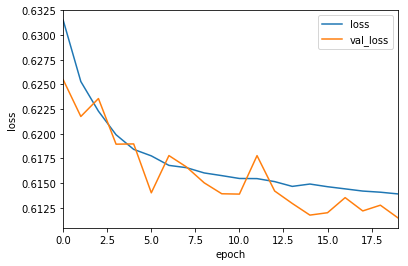

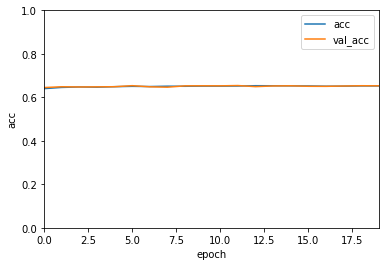

経過時間：156.9582600593567


In [24]:
y104_train = to_categorical(y100_train)
y104_test = to_categorical(y100_test)
model = Sequential()
model.add(Dense(15,activation='relu', input_dim=32)) 
model.add(Dense(8,activation='relu'))
model.add(Dense(6, activation='relu'))
model.add(Dense(2, activation='softmax'))

adam = Adam(lr=0.01)

model.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy']) 
X104_train = std_scaler.fit_transform(X100_train)
X104_test = std_scaler.transform(X100_test)
t1=time.time()
fit = model.fit(X104_train, y104_train,
          epochs=20,
          batch_size=50,validation_data=(X104_test, y104_test))

df = pd.DataFrame(fit.history)
t2=time.time()
df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

df[["acc", "val_acc"]].plot()
plt.ylabel("acc")
plt.xlabel("epoch")
plt.ylim([0,1.0])
plt.show()
elapsed_time = t2-t1
print(f"経過時間：{elapsed_time}")

### 結果まとめ
  |順位 |model                                      |sample  |result |time(sec)|
  |-----|-------------------------------------------|--------|-------|---------|
  |  1  |ランダムフォレスト                         |66.880% |67.031%|257.92   |
  |  2  |決定木                                     |64.880% |65.573%|3.23     |
  |  3  |ニューラルネットワーク                     |65.200% |65.200%|156.96   |
  |  4  |アンサンブル学習(log回帰+決定木+非線形SVM) |65.385% |65.073%|431.15   |
  |  5  |ロジスティック回帰                         |64.433% |64.951%|6.87     |
  
* 2位～4位は正答率の差は0.5%以内なので、いずれを選んでも大差はないように思える。
* sampleと実結果で順位が違うので、気になる場合はランダムフォレスト、NN、アンサンブル学習を選ぶとよい。(時間がかかると差が小さい？)
* 計算時間に大きな差があるので、運用上はそこも考慮すべき、と思う。

### 思ったこと
* 思ったより正答率が上がらなかった。説明変数の選択が悪いと思われるが、特徴選択でも変わらなかった。個人的には70%くらいは超えるものかと思っていた。
* ということは、そもそも特徴選択のやり方が間違っているのでは…と思う。カテゴリ変数の扱い方やまとめ方等考察の余地は大きいと思う。

* わからないことを調べていくうちに様々なライブラリ、手法があり、どんどん新しい手法も増えていっていることを感じた。

* 様々なことに目を向けて、いろんな視点から見ないといけないので、頭の柔軟性も大事だと思う。

* 今回はnanが少なく、dropで対応しても問題ないと思ったが、実際のデータではその扱いも考えないといけない。

* いろいろ考えながらトライアンドエラーで身についていくものかなぁとも思ったため、今後もkaggleには触れていきたいと思う。